In [ ]:
import torch  # PyTorch 임포트트
import torch.nn as nn  # 신경망 모듈 임포트트

# 1x1 컨볼루션
def conv_1_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=1),  # 1x1 컨볼루션 연산 수행 (입력 채널 수, 출력 채널 수)
        nn.ReLU()  # 활성화 함수로 ReLU 적용
    )
    return model  # 생성성 모델 반환

# 3x3 컨볼루션 
def conv_3_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),  # 3x3 컨볼루션 
        nn.ReLU(),  # 활성화 함수 ReLU
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),  
        nn.ReLU(),  
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),  
        nn.ReLU(),  
        nn.MaxPool2d(2, 2)  # 2x2 맥스 풀링으로 맵 크기 감소
    )
    return model  # 생성 모델 반환

# VGG16 모델 클래스 정의
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):  # 클래스 수 입력 받기, 모델 생성
        super(VGG16, self).__init__()  # 부모 클래스의 생성자 호출
        
        # Feature 정의
        self.features = nn.Sequential(
            conv_3_block(3, 64),   # 첫 번째 컨볼루션 (입력, 출력)
            nn.MaxPool2d(2,2),  # 2x2 맥스 풀링 
            conv_3_block(64, 128),  # 두 번째 컨볼루션션
            nn.MaxPool2d(2,2),  
            conv_3_block(128, 256), # 세 번째 컨볼루션 
            conv_1_block(256, 256), # 1x1 컨볼루션
            nn.MaxPool2d(2,2),  
            conv_3_block(256, 512), # 네 번째 컨볼루션 
            conv_1_block(512, 512), 
            nn.MaxPool2d(2,2),  
            conv_3_block(512, 512), # 다섯 번째 컨볼루션
            conv_1_block(512, 512), 
            nn.MaxPool2d(2,2),  
        )
        
        # 출력 크기를 7x7로 맞춤
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),  # 512x7x7을 512로 연결
            nn.ReLU(True),  # ReLU 활성화
            nn.Dropout(),  # 드롭아웃 (과적합 방지)
            nn.Linear(512, 512),  # 512에서 512로 연결
            nn.ReLU(True),  
            nn.Dropout(),  
            nn.Linear(512, num_classes)  # 최종 출력을 num_classes로 맞춤
        )

    def forward(self, x):
        x = self.features(x)  # 컨볼루션 및 풀링 연산을 수행
        x = self.avgpool(x)  # 7x7 크기로 변환
        x = torch.flatten(x,1)  # 2D 특징 맵을 1D 벡터로 변환
        x = self.classifier(x)  
        return x  


In [ ]:
# device 설정 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG16 모델
model = VGG16(64).to(device)

# 손실 함수
loss_func = nn.CrossEntropyLoss()

# 학습률
learning_rate = 0.001

# Adam 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [30]:
import torchvision  # torchvision 라이브러리 임포트
import torchvision.datasets as datasets  # 데이터셋 모듈 임포트
import torchvision.transforms as transforms  # 이미지 변환(transform) 모듈 임포트
from torch.utils.data import DataLoader  # 데이터 로더(DataLoader) 임포트

# Transform 정의 (데이터 전처리)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기를 224x224로 조정 (VGG 모델 입력 크기와 맞춤)
    transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화 (평균: 0.5, 표준편차: 0.5)
])

# CIFAR-10 TRAIN 데이터셋 정의
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, download=True)  
# CIFAR-10 학습 데이터셋 다운로드 및 변환 적용
trainloader = DataLoader(cifar10_train, batch_size=128, shuffle=True, num_workers=2)  
# 데이터로더 정의 (배치 크기: 128, 데이터 섞기: True, 워커 수: 2)

# CIFAR-10 TEST 데이터셋 정의
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, download=True)  
# CIFAR-10 테스트 데이터셋 다운로드 및 변환 적용
testloader = DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)  
# 데이터로더 정의 (배치 크기: 64, 데이터 섞기: False, 워커 수: 2)

# CIFAR-10 클래스 라벨 정의
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  
# CIFAR-10에 포함된 10개의 클래스 라벨


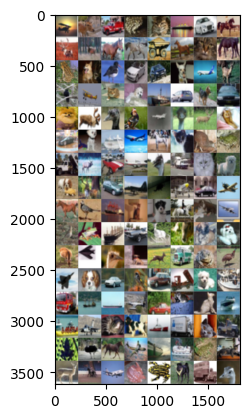

plane  deer truck  frog   cat  ship   car horse  deer  deer horse horse truck horse   cat horse  frog   dog  bird   car   car   dog plane  deer  bird plane   cat   dog  ship   car   dog   car   dog  deer  bird  bird plane  bird  deer   cat   car   dog  ship plane horse   cat  bird  frog truck  deer   car plane  bird truck   cat   dog   dog  deer   car plane   cat plane   car plane horse  bird  ship   cat   dog horse   dog plane  bird  frog  ship   car  deer  deer   dog   dog  deer plane  bird   dog  deer truck  frog  bird plane   dog   car  bird   car truck   dog  ship truck  ship  ship plane   car   cat   cat  ship  ship plane   cat   dog  ship truck   cat truck  frog  bird horse plane  ship  ship  frog   cat  deer horse plane  deer  frog   dog truck  bird


In [ ]:
import torch  # PyTorch 라이브러리 
import torchvision  # torchvision 라이브러리
import matplotlib.pyplot as plt  # Matplotlib 라이브러리
import numpy as np  # NumPy 라이브러리


def imshow(img):
    img = img / 2 + 0.5  # 정규화 해제 (unnormalize)
    npimg = img.numpy()  # 텐서를 넘파이 배열로 변환
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 이미지 차원 순서 변경 (C, H, W → H, W, C)
    plt.show()  

# 이미지 무작위로 가져오기
dataiter = iter(trainloader)  # trainloader의 반복자 생성
images, labels = next(dataiter)  # 첫 번째 배치 가져오기

# 이미지 출력
imshow(torchvision.utils.make_grid(images)) 

batch_size = images.shape[0]  # 현재 배치의 크기 
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))  


In [ ]:
batch_size = 100  # 배치 크기 설정 
learning_rate = 0.0002  # 학습률 설정 
num_epoch = 100  # 전체 학습 반복 횟수 설정


In [ ]:
from tqdm import trange  # tqdm 임포트 추가 (진행 상태 표시)

loss_arr = []  # 손실 값을 저장할 리스트
for i in trange(num_epoch):  # tqdm을 사용해 학습 진행 상태 표시
    for j, (image, label) in enumerate(trainloader):  # 배치 단위로 데이터 가져오기
        x = image.to(device)  # 입력 이미지 GPU/CPU로 이동
        y_ = label.to(device).long()  # 정답 라벨을 long 타입으로 변환 후 이동
        
        optimizer.zero_grad()  # 기울기 초기화
        output = model.forward(x)  # 모델 예측값 계산
        loss = loss_func(output, y_)  # 손실 함수 계산
        loss.backward()  # 기울기 계산
        optimizer.step()  # 옵티마이저로 모델 가중치 업데이트

    if i % 10 == 0:  # 10 에포크마다 출력
        print(f"Epoch [{i}/{num_epoch}], Loss: {loss.item():.4f}")  # 현재 에포크와 손실 값 출력
        loss_arr.append(loss.item())  # 손실 값 리스트에 추가


  0%|          | 0/100 [00:30<?, ?it/s]


RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small

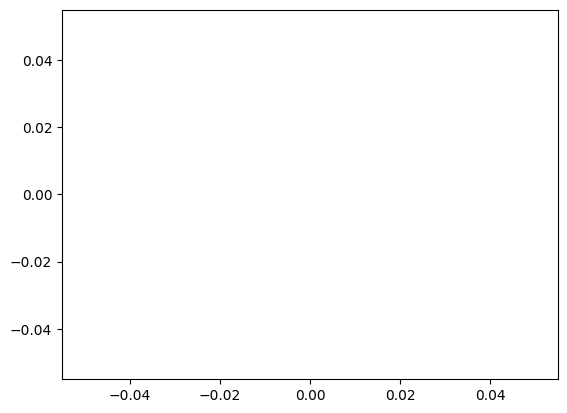

In [ ]:
plt.plot(loss_arr)  # 손실 값 그래프 그리기
plt.show() #그래프 출력

In [ ]:
# 맞은 개수와 전체 개수를 저장할 변수 초기화
correct = 0
total = 0

model.eval()  # 모델을 평가 모드로 설정 (드롭아웃, 배치 정규화 비활성화)

# 인퍼런스 모드를 위해 no_grad 사용 (기울기 계산 비활성화)
with torch.no_grad():
    # 테스트 데이터 로더에서 이미지와 정답 가져오기
    for image, label in testloader:
        
        # 입력 데이터와 정답을 장치(GPU/CPU)로 이동
        x = image.to(device)
        y = label.to(device)

        # 모델에 데이터를 입력하고 예측값 얻기
        output = model.forward(x)
        _, output_index = torch.max(output, 1)  # 가장 높은 확률의 클래스 인덱스 선택

        # 전체 개수 업데이트
        total += label.size(0)  # 현재 배치의 샘플 개수를 total에 추가
        correct += (output_index == y).sum().float()  # 맞춘 개수를 correct에 추가
    
    # 정확도 출력
    print("Accuracy of Test Data: {:.2f}%".format(100 * correct / total))  # 소수점 2자리까지 표시


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small